# predictive uncertainty visualization

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
from matplotlib.ticker import FuncFormatter 
import matplotlib.ticker as ticker
mpl.rcParams['font.size'] = 16
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 14

In [4]:
# Common settings
# import the annual loads
file_dates = ['20220118_full', '20220123', '20220310', '20220311', '20220312', '20220313', '20220314', '20220315', '20220316']
ind_results = [26, 12, 7, 7, 12, 7, 11, 11, 7]
fpaths = [f'../../output/work_run_{fd}/' for fd in file_dates]
# file_dates = ['20220118_full', '20220123', '20220125', '20220126', '20220128', '20220129', '20220130', '20220201', '20220203', '20220204']
# ind_results = [26, 12, 24, 8, 12, 12, 8, 11, 9, 7]
# fpaths = [f'../../output/work_run_{fd}/' for fd in file_dates]
fn_figs = '../../output/figs/'

## Plot metrics

In [5]:
# read files
num_pars = ['13', '12', '11', '10', '9', '8', '6', '4', '1']#, '1']
cols = ['CR_perc', 'OLF_perc', 'CR_std', 'OLF_std', 'AWI_perc', 'MAD', 'AWI_std']
metric_pars_unc = pd.DataFrame(columns = cols, index=num_pars)
metric_total_unc = pd.DataFrame(columns = cols, index=num_pars)
objective_functions = pd.DataFrame()

k = 0
for fp in fpaths:
    metric_pars_unc.loc[num_pars[k], :] = pd.read_csv(fp +'metric_param_unc.csv', index_col='Unnamed: 0').values
    metric_total_unc.loc[num_pars[k], :] = pd.read_csv(fp +'metric_total_unc.csv', index_col='Unnamed: 0').values
    df_temp = pd.read_csv(fp +'objective_functions.csv', index_col='Unnamed: 0')
    df_temp['num_pars'] = num_pars[k]
    objective_functions = pd.concat([objective_functions, df_temp])
    k += 1
# cols = metric_dict[file_dates[k-1]].columns
objective_functions = objective_functions.reset_index(drop=True).reset_index()
objective_functions['PBIAS'] = objective_functions['PBIAS'].values / 100

In [6]:
cols

['CR_perc', 'OLF_perc', 'CR_std', 'OLF_std', 'AWI_perc', 'MAD', 'AWI_std']

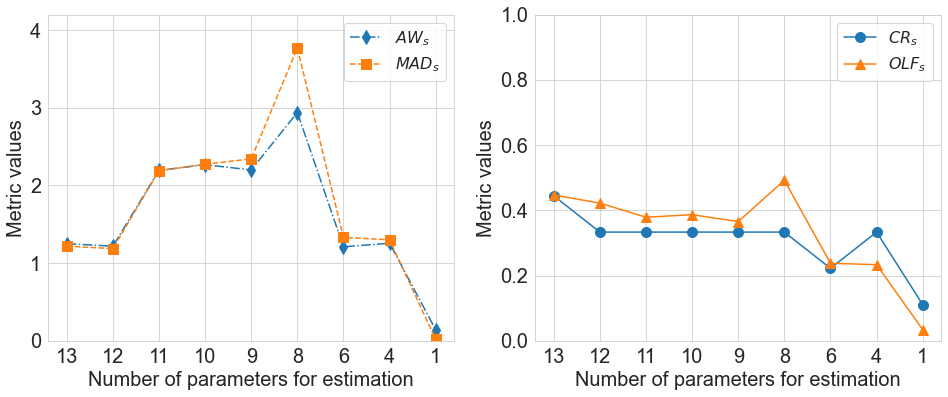

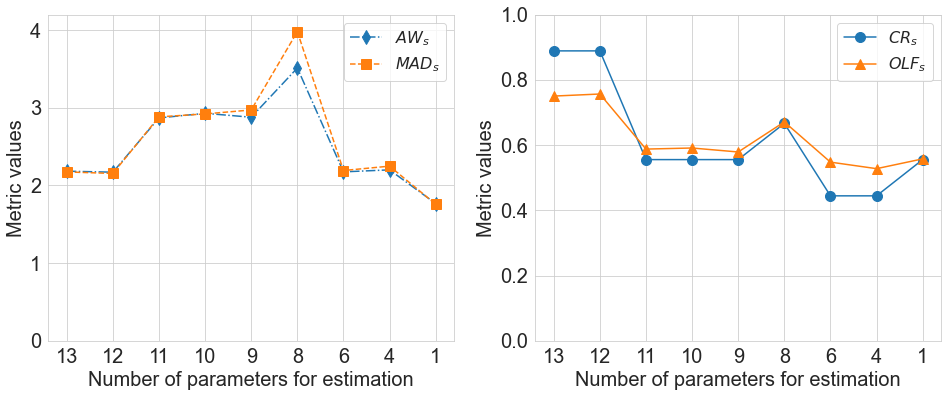

In [7]:
# plotting metrics
sns.set_style('whitegrid')
ylabs = ['Param_unc', 'Total_unc']
cols = metric_pars_unc.columns
unc_ALL = [metric_pars_unc, metric_total_unc]
for jj in range(2):
    fig, axes = plt.subplots(1, 2, figsize=(8*2, 6*1), sharey=False)
    # unc_ALL[jj][cols[0]].plot(ax=axes[1], marker='o', ms=10)
    # unc_ALL[jj][cols[1]].plot(ax=axes[1], marker='^', ms=10)
    unc_ALL[jj][cols[2]].plot(ax=axes[1], marker='o',  ms=10) #ls='-.',
    unc_ALL[jj][cols[3]].plot(ax=axes[1], marker='^',  ms=10) #ls='--',
    # unc_ALL[jj][cols[4]].plot(ax=axes[0], marker='d', ls='-.', ms=10)
    unc_ALL[jj][cols[6]].plot(ax=axes[0], marker='d', ms=10, ls='-.')
    (unc_ALL[jj][cols[5]]*6).plot(ax=axes[0], marker='s', ls='--', ms=10)
    
    for ii in range(2):    
        axes[ii].set_xlabel('Number of parameters for estimation')
        axes[ii].xaxis.set_major_locator(ticker.FixedLocator(np.arange(9)))
        axes[ii].set_xticklabels(num_pars)
        axes[ii].set_ylabel('Metric values')
    axes[0].set_ylim(0, 4.2)
    axes[1].set_ylim(0, 1)
    axes[1].legend([r'$CR_{s}$', r'$OLF_{s}$'], loc='upper right', fontsize=16) #r'$CR_{p}$', r'$OLF_{p}$', 
    axes[0].legend([r'$AW_{s}$', r'$MAD_{s}$'], loc='upper right', fontsize=16) #, r'$AW_{s}$'
    plt.savefig(f'{fn_figs}metric_{ylabs[jj]}_doubleY_std.png', dpi=300, format='png')

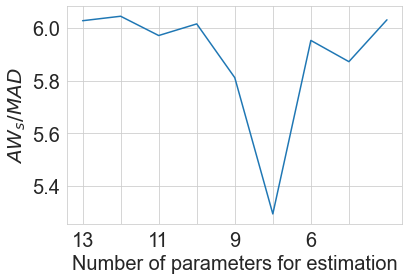

In [12]:
# Plot the ratio of AW to MAD
ax = (metric_total_unc['AWI_std'] / metric_total_unc['MAD']).plot()
ax.set_xlabel('Number of parameters for estimation')
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(8)))
ax.set_ylabel(r'$AW_{s} / MAD$')
plt.savefig(f'{fn_figs}ratio_AW_MAD.png', format='png', dpi=300)

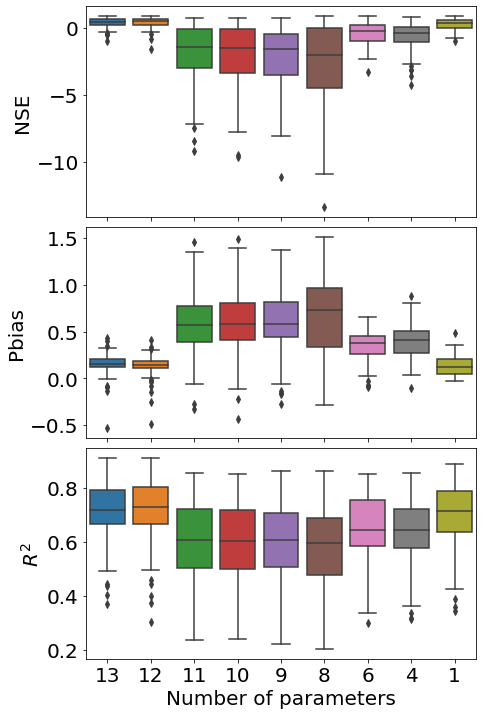

In [7]:
# Plot objective functions
import seaborn as sns
fig, axes = plt.subplots(3, 1, figsize=(7*1, 4*3), sharex=True)
metrics = ['NSE', 'PBIAS', 'R2']
for ii in range(3):
    sns.boxplot(data=objective_functions,  x='num_pars', y=metrics[ii], ax=axes[ii])
    axes[ii].set_xlabel('')
axes[1].set_ylabel('Pbias')
axes[2].set_xlabel('Number of parameters')
axes[2].set_ylabel(r'$R^2$')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig(f'{fn_figs}objective_functions_subplots.png', format='png', dpi=300)

In [14]:
cols_obj = ['NSE_mean', 'PBIAS_mean', 'R2_mean', 'NSE_std', 'PBIAS_std', 'R2_std', 'NSE_best', 'PBIAS_best', 'R2_best', 'NSE_worst', 'PBIAS_worst', 'R2_worst']
df_summary = pd.DataFrame(index=num_pars, columns=cols_obj)
for ii in num_pars:
    df_summary.loc[ii, cols_obj[0:3]] = objective_functions[objective_functions['num_pars'] == ii].mean()[1:-1].values
    df_summary.loc[ii, cols_obj[3:6]] = objective_functions[objective_functions['num_pars'] == ii].std()[1:].values
    df_summary.loc[ii, cols_obj[6:9]] = objective_functions[objective_functions['num_pars'] == ii].max()[1:-1].values
    df_summary.loc[ii, cols_obj[7]] = objective_functions[objective_functions['num_pars'] == ii]['PBIAS'].abs().min()
    df_summary.loc[ii, cols_obj[9:12]] = objective_functions[objective_functions['num_pars'] == ii].min()[1:-1].values
    df_summary.loc[ii, cols_obj[10]] = objective_functions[objective_functions['num_pars'] == ii]['PBIAS'].abs().max()
cols_obj_order = ['NSE_mean', 'NSE_std', 'NSE_best','NSE_worst', 'PBIAS_mean', 'PBIAS_std', 'PBIAS_best','PBIAS_worst', 'R2_mean', 'R2_std', 'R2_best', 'R2_worst']
df_summary[cols_obj_order].to_csv(f'{fn_figs}objective_summary.csv')

## Plot Parameter metrics

In [4]:
# read files
fn_figs = '../../output/test/figs/'
num_pars = ['13', '12', '11', '10', '9', '8', '6', '4', '1']#, '3', '1']
par_orders = ['goEMC', 'fEMC', 'DRF', 'cEMC', 'gfEMC', 'cDWC', 'oEMC', 'fDWC', 'DWC', 'gfDWC', 'goDWC', 'DRP', 'oDWC']
# par_orders = ['oDWC', 'DRP', 'goDWC', 'gfDWC', 'DWC', 'fDWC', 'gfEMC']
par_orders.reverse()
par_iqr = pd.read_csv(fn_figs + 'parameter_iqr.csv')[par_orders].round(2)
par_iqr_change = ((par_iqr - par_iqr.iloc[0].values) / par_iqr.iloc[0].values).round(2)
par_mad = pd.read_csv(fn_figs + 'parameter_quantile25.csv')[par_orders].round(2)
par_range = pd.read_csv(fn_figs + 'parameter_quantile75.csv')[par_orders].round(2)
par_metrics = [par_iqr, par_mad, par_range, par_iqr_change]
metrics_names = ['IQR', 'Q25', 'Q75', '% of IQR']

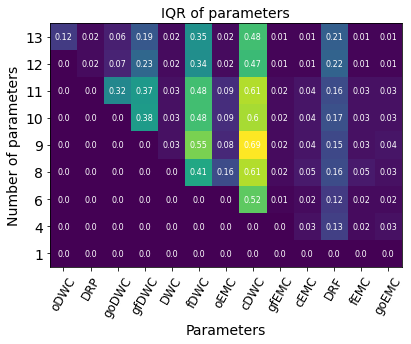

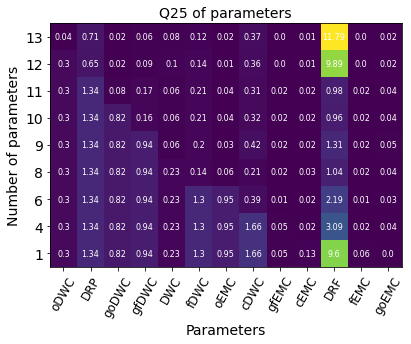

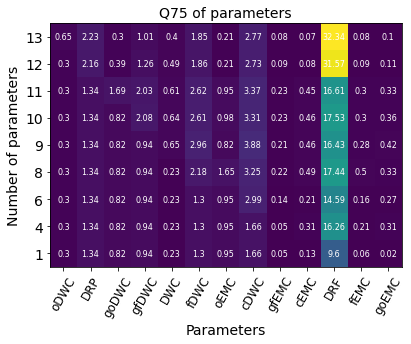

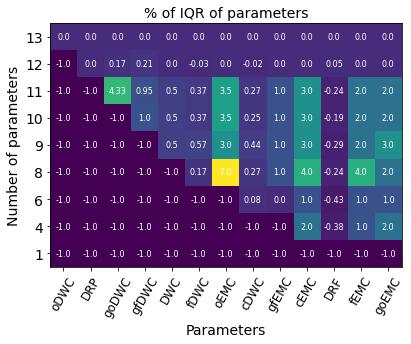

In [5]:
for ii in range(len(metrics_names)):
    fig, ax = plt.subplots(figsize=(6, 5))
    values = par_metrics[ii].values
    im = ax.imshow(values)
    # Show all ticks and label them with the respective list entries
    ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(len(num_pars))))
    ax.set_yticklabels(num_pars,fontsize=14)
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(13)))
    ax.set_xticklabels(par_orders, rotation=60, fontsize=12)
    ax.set_ylabel('Number of parameters',fontsize=14)
    ax.set_xlabel('Parameters',fontsize=14)
    # Loop over data dimensions and create text annotations.
    for i in range(len(num_pars)):
        for j in range(len(par_orders)):
            text = ax.text(j, i, values[i, j],
                           ha="center", va="center", color="w", fontsize=8)

    ax.set_title(f'{metrics_names[ii]} of parameters', fontsize=14)
    fig.tight_layout()
    plt.savefig(f'{fn_figs}{metrics_names[ii]}_parameters.png', format='png', dpi=300)

## Violin plot

In [18]:
fns = [f'126001A.{ind_result}.obs.csv' for ind_result in ind_results]
k = 7
file_date, fpath, fn = file_dates[k], fpaths[k], fns[k]
fn_meas = '126001A.base.obs.csv'
fn_total_unc = 'total_uncertainty.csv'
log_load = True

In [19]:
df = pd.read_csv(fpath + fn, index_col = 'real_name')
df_total_unc = pd.read_csv(fpath + fn_total_unc, index_col = 'real_name')
# select results of which the pbias is with 15%
# df = df[(df.din_pbias < 15) & (df.din_pbias > -15)]
df_meas = pd.read_csv(fpath + fn_meas, index_col = 'real_name')
if log_load:
    df_meas.loc[:, 'din_2009':] = 10**(df_meas.loc[:, 'din_2009':])
    df.loc[:, 'din_2009':] = 10**(df.loc[:, 'din_2009':])

df['average'] = df.loc[:, 'din_2009':'din_2017'].mean(axis=1).values
df_meas['average'] = df_meas.loc[:, 'din_2009':'din_2017'].mean(axis=1).values
df_total_unc['average'] = df_total_unc.loc[:, 'din_2009':'din_2017'].mean(axis=1).values

# obs data
obs_annual = [52.093, 99.478, 44.064, 57.936, 53.449, 21.858, 38.561, 51.843, 14.176]
obs_annual.append(np.round(np.mean(obs_annual), 2))
obs_df = pd.DataFrame(data=obs_annual, index = [*np.arange(2009, 2018), 'average'], columns=['Annual loads'])

In [20]:
# reorganize the dataframe for plotting
df_plot = pd.DataFrame(data = df.values[:, 1:].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df.shape[0], 0).T
df_plot['year'] = year_col
df_plot['type'] = 'Parameter uncertainty'

df_meas_plot = pd.DataFrame(data = df_meas.values[:, 1:].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df_meas.shape[0], 0).T
df_meas_plot['year'] = year_col
df_meas_plot['type'] = 'Measurement realization'

df_total_unc_plot = pd.DataFrame(data = df_total_unc.values[:, :].T.flatten(), columns=['Annual loads'])
year_col = np.repeat(np.arange(2009, 2019), df_total_unc.shape[0], 0).T
df_total_unc_plot['year'] = year_col
df_total_unc_plot['type'] = 'Total Uncertainty'

df_plot = pd.concat([df_meas_plot, df_plot])
df_total_unc_plot = pd.concat([df_meas_plot, df_total_unc_plot])
df_total_unc_plot = df_total_unc_plot.reset_index(drop=True)

df_plot.reset_index().tail()

,index,Annual loads,year,type
1995,995,72.195702,2018,Parameter uncertainty
1996,996,53.441916,2018,Parameter uncertainty
1997,997,72.116108,2018,Parameter uncertainty
1998,998,73.317449,2018,Parameter uncertainty
1999,999,64.847702,2018,Parameter uncertainty


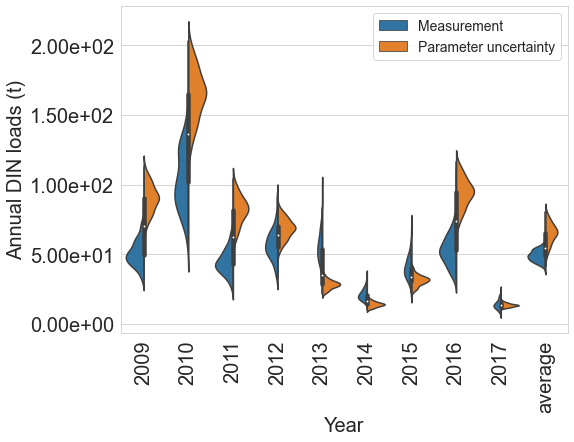

In [21]:
# Plot the uncertainty of annual loads
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='year', y='Annual loads', data=df_plot, hue='type', split=True);
ax.legend(handles=ax.legend_.legendHandles, labels=['Measurement', 'Parameter uncertainty'])
# obs_df.plot(y=[0], linewidth=0, ax=ax, marker='d', markersize=5, color='r', legend=['Obs']);
ax.set_xticklabels([*np.arange(2009, 2018), 'average'], rotation=90);
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
ax.set_xlabel('Year')
ax.set_ylabel('Annual DIN loads (t)')
plt.savefig(f'{fn_figs}parameter_uncertainty_{file_date}.png', dpi=300, format='png')

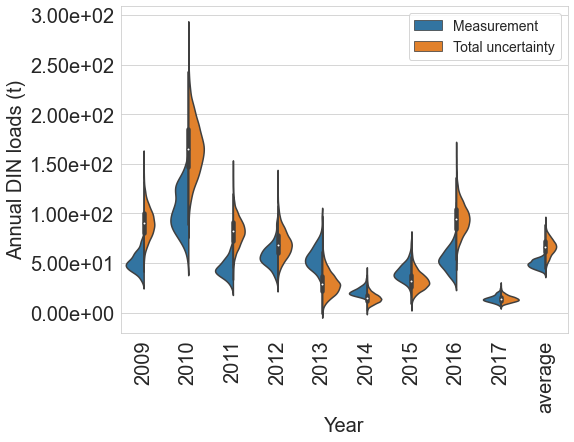

In [22]:
# Plot the uncertainty of annual loads
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='year', y='Annual loads', data=df_total_unc_plot, hue='type', split=True);
ax.legend(handles=ax.legend_.legendHandles, labels=['Measurement', 'Total uncertainty'])
# obs_df.plot(y=[0], linewidth=0, ax=ax, marker='d', markersize=5, color='r', legend=['Obs']);
ax.set_xticklabels([*np.arange(2009, 2018), 'average'], rotation=90);
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
ax.set_xlabel('Year')
ax.set_ylabel('Annual DIN loads (t)')
plt.savefig(f'{fn_figs}total_uncertainty_{file_date}.png', dpi=300, format='png')